In [4]:
import colorsys
import os

import cv2
import numpy as np
from pyquaternion import Quaternion

from nuscenes.eval.common.utils import quaternion_yaw
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.prediction.helper import angle_of_rotation, angle_diff
from nuscenes.prediction.input_representation.combinators import Rasterizer
from nuscenes.prediction.input_representation.interface import \
    StaticLayerRepresentation, AgentRepresentation
from nuscenes.prediction.input_representation.utils import get_crops, get_rotation_matrix, convert_to_pixel_coords

import matplotlib.pyplot as plt
%matplotlib inline

from nuscenes.prediction.input_representation.combinators import Rasterizer
from nuscenes.prediction import PredictHelper

from typing import Any, Dict, List, Tuple, Callable

from nuscenes.prediction.helper import quaternion_yaw

%matplotlib inline
from nuscenes.nuscenes import NuScenes
import matplotlib.pyplot as plt
import numpy as np
import copy
import PIL
import os
from skimage import color
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from nuscenes.utils.data_classes import LidarPointCloud
from pyquaternion import Quaternion
nusc = NuScenes(version='v1.0-mini', dataroot='/datasets/home/44/344/abkandoi/nuscenes-mini-data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.8 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


In [30]:
History = Dict[str, List[Dict[str, Any]]]


def pixels_to_box_corners(row_pixel: int,
                          column_pixel: int,
                          length_in_pixels: float,
                          width_in_pixels: float,
                          yaw_in_radians: float) -> np.ndarray:
    """
    Computes four corners of 2d bounding box for agent.
    The coordinates of the box are in pixels.
    :param row_pixel: Row pixel of the agent.
    :param column_pixel: Column pixel of the agent.
    :param length_in_pixels: Length of the agent.
    :param width_in_pixels: Width of the agent.
    :param yaw_in_radians: Yaw of the agent (global coordinates).
    :return: numpy array representing the four corners of the agent.
    """

    # cv2 has the convention where they flip rows and columns so it matches
    # the convention of x and y on a coordinate plane
    # Also, a positive angle is a clockwise rotation as opposed to counterclockwise
    # so that is why we negate the rotation angle
    coord_tuple = ((column_pixel, row_pixel), (length_in_pixels, width_in_pixels), -yaw_in_radians * 180 / np.pi)

    box = cv2.boxPoints(coord_tuple)

    return box


def get_track_box(annotation: Dict[str, Any],
                  center_coordinates: Tuple[float, float],
                  center_pixels: Tuple[float, float],
                  resolution: float = 0.1) -> np.ndarray:
    """
    Get four corners of bounding box for agent in pixels.
    :param annotation: The annotation record of the agent.
    :param center_coordinates: (x, y) coordinates in global frame
        of the center of the image.
    :param center_pixels: (row_index, column_index) location of the center
        of the image in pixel coordinates.
    :param resolution: Resolution pixels/meter of the image.
    """

    assert resolution > 0

    location = annotation['translation'][:2]
    yaw_in_radians = quaternion_yaw(Quaternion(annotation['rotation']))

    #print('yaw_in_radians', yaw_in_radians)
    row_pixel, column_pixel = convert_to_pixel_coords(location,
                                                      center_coordinates,
                                                      center_pixels, resolution)
    #print('row_pixel, column_pixel', row_pixel, column_pixel)
    #print('center_pixels', center_pixels)

    width = annotation['size'][0] / resolution
    length = annotation['size'][1] / resolution

    # Width and length are switched here so that we can draw them along the x-axis as
    # opposed to the y. This makes rotation easier.
    return pixels_to_box_corners(row_pixel, column_pixel, length, width, yaw_in_radians)


def reverse_history(history: History) -> History:
    """
    Reverse history so that most distant observations are first.
    We do this because we want to draw more recent bounding boxes on top of older ones.
    :param history: result of get_past_for_sample PredictHelper method.
    :return: History with the values reversed.
    """
    return {token: anns[::-1] for token, anns in history.items()}


def add_present_time_to_history(current_time: List[Dict[str, Any]],
                                history: History) -> History:
    """
    Adds the sample annotation records from the current time to the
    history object.
    :param current_time: List of sample annotation records from the
        current time. Result of get_annotations_for_sample method of
        PredictHelper.
    :param history: Result of get_past_for_sample method of PredictHelper.
    :return: History with values from current_time appended.
    """

    for annotation in current_time:
        token = annotation['instance_token']

        if token in history:

            # We append because we've reversed the history
            history[token].append(annotation)

        else:
            history[token] = [annotation]

    return history


def fade_color(color: Tuple[int, int, int],
               step: int,
               total_number_of_steps: int) -> Tuple[int, int, int]:
    """
    Fades a color so that past observations are darker in the image.
    :param color: Tuple of ints describing an RGB color.
    :param step: The current time step.
    :param total_number_of_steps: The total number of time steps
        the agent has in the image.
    :return: Tuple representing faded rgb color.
    """

    LOWEST_VALUE = 0.4

    if step == total_number_of_steps:
        return color

    hsv_color = colorsys.rgb_to_hsv(*color)

    increment = (float(hsv_color[2])/255. - LOWEST_VALUE) / total_number_of_steps

    new_value = LOWEST_VALUE + step * increment

    new_rgb = colorsys.hsv_to_rgb(float(hsv_color[0]),
                                  float(hsv_color[1]),
                                  new_value * 255.)
    return new_rgb


def default_colors(category_name: str) -> Tuple[int, int, int]:
    """
    Maps a category name to an rgb color (without fading).
    :param category_name: Name of object category for the annotation.
    :return: Tuple representing rgb color.
    """

    if 'vehicle' in category_name:
        return 255, 255, 0  # yellow
    elif 'object' in category_name:
        return 204, 0, 204  # violet
    elif 'human' in category_name or 'animal' in category_name:
        return 255, 153, 51  # orange
    else:
        raise ValueError(f"Cannot map {category_name} to a color.")


def draw_agent_boxes(center_agent_annotation: Dict[str, Any],
                     center_agent_pixels: Tuple[float, float],
                     agent_history: History,
                     base_image: np.ndarray,
                     get_color: Callable[[str], Tuple[int, int, int]],
                     resolution: float = 0.1) -> None:
    """
    Draws past sequence of agent boxes on the image.
    :param center_agent_annotation: Annotation record for the agent
        that is in the center of the image.
    :param center_agent_pixels: Pixel location of the agent in the
        center of the image.
    :param agent_history: History for all agents in the scene.
    :param base_image: Image to draw the agents in.
    :param get_color: Mapping from category_name to RGB tuple.
    :param resolution: Size of the image in pixels / meter.
    :return: None.
    """

    agent_x, agent_y = center_agent_annotation['translation'][:2]
    print('agent_x, agent_y are', agent_x, agent_y)

    for instance_token, annotations in agent_history.items():

        num_points = len(annotations)

        for i, annotation in enumerate(annotations):
            #if instance_token != center_agent_annotation['instance_token']:
            #    continue

            box = get_track_box(annotation, (agent_x, agent_y+25), center_agent_pixels, resolution)
            #box2 = get_track_box(annotation, (agent_x, agent_y), center_agent_pixels, resolution)
            #cv2.fillPoly(base_image, pts=[np.int0(box2)], color=(255,0,0))
            #print(box)
            #print(box.shape)

            if instance_token == center_agent_annotation['instance_token']:
                #continue
                color = (255, 0, 0)
                print('center agent')
            else:
                #continue
                if 'object' in annotation['category_name']:
                    #print(annotation['category_name'])
                    continue
                    color = get_color(annotation['category_name'])
                    color = (255,255,255)
                else:
                    color = (255,255,255)

            # Don't fade the colors if there is no history
            if num_points > 1:
                #color = (0,0,0)
                color = fade_color(color, i, num_points - 1)
            if color == (255,0,0):
                color = (255,255,255)
            cv2.fillPoly(base_image, pts=[np.int0(box)], color=color)

def get_target_vehicle_box(ego_pose: Dict[str, Any],
                  center_coordinates: Tuple[float, float],
                  center_pixels: Tuple[float, float],
                  resolution: float = 0.1) -> np.ndarray:
    location = ego_pose['translation'][:2]
    yaw_in_radians = quaternion_yaw(Quaternion(ego_pose['rotation']))

    row_pixel, column_pixel = convert_to_pixel_coords(location,
                                                      center_coordinates,
                                                      center_pixels, resolution)
    
    width = 2 / resolution
    length = 5 / resolution

    # Width and length are switched here so that we can draw them along the x-axis as
    # opposed to the y. This makes rotation easier.
    return pixels_to_box_corners(row_pixel, column_pixel, length, width, yaw_in_radians)
            
def draw_target_vehicle(ego_pose: Dict[str, Any],
                        ref_ego_pose: Dict[str, Any],
                        center_agent_pixels: Tuple[float, float],
                        base_image: np.ndarray,
                        resolution: float = 0.1) -> None:
    color = (255, 255, 255)
    ref_loc_x, ref_loc_y = ref_ego_pose['translation'][:2]
    box = get_target_vehicle_box(ego_pose, (ref_loc_x, ref_loc_y), center_agent_pixels, resolution)
    
    cv2.fillPoly(base_image, pts=[np.int0(box)], color=color)
    
def draw_target_vehicle_red(ego_pose: Dict[str, Any],
                        ref_ego_pose: Dict[str, Any],
                        center_agent_pixels: Tuple[float, float],
                        base_image: np.ndarray,
                        resolution: float = 0.1) -> None:
    color = (255, 0, 0)
    ref_loc_x, ref_loc_y = ref_ego_pose['translation'][:2]
    box = get_target_vehicle_box(ego_pose, (ref_loc_x, ref_loc_y), center_agent_pixels, resolution)
    
    cv2.fillPoly(base_image, pts=[np.int0(box)], color=color)
    
def draw_other_vehicle_boxes(ref_ego_pose: Dict[str, Any],
                        center_agent_pixels: Tuple[float, float],
                        vehicle_history: History,
                        base_image: np.ndarray,
                        resolution: float = 0.1) -> None:
    color = (255, 255, 255)
    ref_loc_x, ref_loc_y = ref_ego_pose['translation'][:2]

    for instance_token, annotations in vehicle_history.items():

        num_points = len(annotations)

        for i, annotation in enumerate(annotations):

            box = get_track_box(annotation, (ref_loc_x, ref_loc_y), center_agent_pixels, resolution)

            if 'object' in annotation['category_name']:
                continue
            
            cv2.fillPoly(base_image, pts=[np.int0(box)], color=color)

def draw_obstacle_boxes(ref_ego_pose: Dict[str, Any],
                        center_agent_pixels: Tuple[float, float],
                        vehicle_history: History,
                        base_image: np.ndarray,
                        resolution: float = 0.1) -> None:
    color = (255, 255, 255)
    ref_loc_x, ref_loc_y = ref_ego_pose['translation'][:2]

    for instance_token, annotations in vehicle_history.items():

        num_points = len(annotations)

        for i, annotation in enumerate(annotations):

            box = get_track_box(annotation, (ref_loc_x, ref_loc_y), center_agent_pixels, resolution)

            if 'object' not in annotation['category_name']:
                continue
            
            cv2.fillPoly(base_image, pts=[np.int0(box)], color=color)            
            
class ObstacleAgentRepresentation(AgentRepresentation):
    def __init__(self, helper: PredictHelper,
                 resolution: float = 0.1,  # meters / pixel
                 meters_ahead: float = 40, meters_behind: float = 10,
                 meters_left: float = 25, meters_right: float = 25):
        self.helper = helper
        
        if not resolution > 0:
            raise ValueError(f"Resolution must be positive. Received {resolution}.")
        
        self.resolution = resolution
        
        self.meters_ahead = meters_ahead
        self.meters_behind = meters_behind
        self.meters_left = meters_left
        self.meters_right = meters_right
    
    def make_representation(self, ego_pose: Dict[str, Any],
                            ref_ego_pose: Dict[str, Any],
                            sample_token: str) -> np.ndarray:
        # Taking radius around track before to ensure all actors are in image
        buffer = max([self.meters_ahead, self.meters_behind,
                      self.meters_left, self.meters_right]) * 2

        image_side_length = int(buffer/self.resolution)
        
        # We will center the track in the image
        central_track_pixels = ((image_side_length / 2), (image_side_length / 2))

        base_image = np.zeros((image_side_length, image_side_length, 3))
        
        history = self.helper.get_past_for_sample(sample_token,
                                                  0,
                                                  in_agent_frame=False,
                                                  just_xy=False)
        history = reverse_history(history)

        present_time = self.helper.get_annotations_for_sample(sample_token)

        history = add_present_time_to_history(present_time, history)
        

        draw_obstacle_boxes(ref_ego_pose, central_track_pixels,
                         history, base_image, resolution=self.resolution)
        
        
        ref_pose_yaw = quaternion_yaw(Quaternion(ref_ego_pose['rotation']))
        rotation_mat = get_rotation_matrix(base_image.shape, ref_pose_yaw+np.pi/2)

        rotated_image = cv2.warpAffine(base_image, rotation_mat, (base_image.shape[1],
                                                                  base_image.shape[0]))

        row_crop, col_crop = get_crops(self.meters_ahead, self.meters_behind,
                                       self.meters_left, self.meters_right, self.resolution,
                                       image_side_length)

        return rotated_image[row_crop, col_crop].astype('uint8')
    
class OtherVehicleRepresentation(AgentRepresentation):
    def __init__(self, helper: PredictHelper,
                 resolution: float = 0.1,  # meters / pixel
                 meters_ahead: float = 40, meters_behind: float = 10,
                 meters_left: float = 25, meters_right: float = 25):
        self.helper = helper
        
        if not resolution > 0:
            raise ValueError(f"Resolution must be positive. Received {resolution}.")
        
        self.resolution = resolution
        
        self.meters_ahead = meters_ahead
        self.meters_behind = meters_behind
        self.meters_left = meters_left
        self.meters_right = meters_right
    
    def make_representation(self, ego_pose: Dict[str, Any],
                            ref_ego_pose: Dict[str, Any],
                            sample_token: str) -> np.ndarray:
        # Taking radius around track before to ensure all actors are in image
        buffer = max([self.meters_ahead, self.meters_behind,
                      self.meters_left, self.meters_right]) * 2

        image_side_length = int(buffer/self.resolution)
        
        # We will center the track in the image
        central_track_pixels = ((image_side_length / 2), (image_side_length / 2))

        base_image = np.zeros((image_side_length, image_side_length, 3))
        
        history = self.helper.get_past_for_sample(sample_token,
                                                  0,
                                                  in_agent_frame=False,
                                                  just_xy=False)
        history = reverse_history(history)

        present_time = self.helper.get_annotations_for_sample(sample_token)

        history = add_present_time_to_history(present_time, history)
        

        draw_other_vehicle_boxes(ref_ego_pose, central_track_pixels,
                         history, base_image, resolution=self.resolution)
        
        #draw_target_vehicle_red(ego_pose, ref_ego_pose, central_track_pixels,
        #                     base_image, resolution=self.resolution)
        
        ref_pose_yaw = quaternion_yaw(Quaternion(ref_ego_pose['rotation']))
        rotation_mat = get_rotation_matrix(base_image.shape, ref_pose_yaw+np.pi/2)

        rotated_image = cv2.warpAffine(base_image, rotation_mat, (base_image.shape[1],
                                                                  base_image.shape[0]))

        row_crop, col_crop = get_crops(self.meters_ahead, self.meters_behind,
                                       self.meters_left, self.meters_right, self.resolution,
                                       image_side_length)

        return rotated_image[row_crop, col_crop].astype('uint8')
        
    
class TargetVehicleRepresentation(AgentRepresentation):
    def __init__(self, helper: PredictHelper,
                 resolution: float = 0.1,  # meters / pixel
                 meters_ahead: float = 40, meters_behind: float = 10,
                 meters_left: float = 25, meters_right: float = 25):
        self.helper = helper
        
        if not resolution > 0:
            raise ValueError(f"Resolution must be positive. Received {resolution}.")
        
        self.resolution = resolution
        
        self.meters_ahead = meters_ahead
        self.meters_behind = meters_behind
        self.meters_left = meters_left
        self.meters_right = meters_right
    
    def make_representation(self, ego_pose: Dict[str, Any],
                            ref_ego_pose: Dict[str, Any],
                            sample_token: str) -> np.ndarray:
        # Taking radius around track before to ensure all actors are in image
        buffer = max([self.meters_ahead, self.meters_behind,
                      self.meters_left, self.meters_right]) * 2

        image_side_length = int(buffer/self.resolution)
        
        # We will center the track in the image
        central_track_pixels = ((image_side_length / 2), (image_side_length / 2))

        base_image = np.zeros((image_side_length, image_side_length, 3))
        
        draw_target_vehicle(ego_pose, ref_ego_pose, central_track_pixels,
                             base_image, resolution=self.resolution)
        
        #return base_image.astype('uint8')
        
        ref_pose_yaw = quaternion_yaw(Quaternion(ref_ego_pose['rotation']))
        rotation_mat = get_rotation_matrix(base_image.shape, ref_pose_yaw+np.pi/2)

        rotated_image = cv2.warpAffine(base_image, rotation_mat, (base_image.shape[1],
                                                                  base_image.shape[0]))

        row_crop, col_crop = get_crops(self.meters_ahead, self.meters_behind,
                                       self.meters_left, self.meters_right, self.resolution,
                                       image_side_length)

        return rotated_image[row_crop, col_crop].astype('uint8')
        
        
        
            
class AgentBoxesWithFadedHistory(AgentRepresentation):
    """
    Represents the past sequence of agent states as a three-channel
    image with faded 2d boxes.
    """

    def __init__(self, helper: PredictHelper,
                 seconds_of_history: float = 2,
                 frequency_in_hz: float = 2,
                 resolution: float = 0.1,  # meters / pixel
                 meters_ahead: float = 40, meters_behind: float = 10,
                 meters_left: float = 25, meters_right: float = 25,
                 color_mapping: Callable[[str], Tuple[int, int, int]] = None):

        self.helper = helper
        self.seconds_of_history = seconds_of_history
        self.frequency_in_hz = frequency_in_hz

        if not resolution > 0:
            raise ValueError(f"Resolution must be positive. Received {resolution}.")

        self.resolution = resolution

        self.meters_ahead = meters_ahead
        self.meters_behind = meters_behind
        self.meters_left = meters_left
        self.meters_right = meters_right

        if not color_mapping:
            color_mapping = default_colors

        self.color_mapping = color_mapping

    def make_representation(self, instance_token: str, sample_token: str) -> np.ndarray:
        """
        Draws agent boxes with faded history into a black background.
        :param instance_token: Instance token.
        :param sample_token: Sample token.
        :return: np.ndarray representing a 3 channel image.
        """

        # Taking radius around track before to ensure all actors are in image
        buffer = max([self.meters_ahead, self.meters_behind,
                      self.meters_left, self.meters_right]) * 2

        image_side_length = int(buffer/self.resolution)

        # We will center the track in the image
        central_track_pixels = ((image_side_length / 2), (image_side_length / 2))

        base_image = np.zeros((image_side_length, image_side_length, 3))

        history = self.helper.get_past_for_sample(sample_token,
                                                  self.seconds_of_history,
                                                  in_agent_frame=False,
                                                  just_xy=False)
        history = reverse_history(history)

        present_time = self.helper.get_annotations_for_sample(sample_token)

        history = add_present_time_to_history(present_time, history)

        center_agent_annotation = self.helper.get_sample_annotation(instance_token, sample_token)

        draw_agent_boxes(center_agent_annotation, central_track_pixels,
                         history, base_image, resolution=self.resolution, get_color=self.color_mapping)

        center_agent_yaw = quaternion_yaw(Quaternion(center_agent_annotation['rotation']))
        rotation_mat = get_rotation_matrix(base_image.shape, center_agent_yaw)
#         return base_image.astype('uint8')

        rotated_image = cv2.warpAffine(base_image, rotation_mat, (base_image.shape[1],
                                                                  base_image.shape[0]))

        row_crop, col_crop = get_crops(self.meters_ahead, self.meters_behind,
                                       self.meters_left, self.meters_right, self.resolution,
                                       image_side_length)

        return rotated_image[row_crop, col_crop].astype('uint8')

In [21]:

Color = Tuple[float, float, float]


def load_all_maps(helper: PredictHelper) -> Dict[str, NuScenesMap]:
    """
    Loads all NuScenesMap instances for all available maps.
    :param helper: Instance of PredictHelper.
    :return: Mapping from map-name to the NuScenesMap api instance.
    """
    dataroot = helper.data.dataroot

    json_files = filter(lambda f: "json" in f and "prediction_scenes" not in f,
                        os.listdir(os.path.join(dataroot, "maps")))
    maps = {}

    for map_file in json_files:

        map_name = str(map_file.split(".")[0])

        print(f'static_layers.py - Loading Map: {map_name}')

        maps[map_name] = NuScenesMap(dataroot, map_name=map_name)

    return maps


def get_patchbox(x_in_meters: float, y_in_meters: float,
                 image_side_length: float) -> Tuple[float, float, float, float]:
    """
    Gets the patchbox representing the area to crop the base image.
    :param x_in_meters: X coordinate.
    :param y_in_meters: Y coordiante.
    :param image_side_length: Length of the image.
    :return: Patch box tuple.
    """

    patch_box = (x_in_meters, y_in_meters, image_side_length, image_side_length)

    return patch_box


def change_color_of_binary_mask(image: np.ndarray, color: Color) -> np.ndarray:
    """
    Changes color of binary mask. The image has values 0 or 1 but has three channels.
    :param image: Image with either 0 or 1 values and three channels.
    :param color: RGB color tuple.
    :return: Image with color changed (type uint8).
    """

    image = image * color

    # Return as type int so cv2 can manipulate it later.
    image = image.astype("uint8")

    return image


def correct_yaw(yaw: float) -> float:
    """
    nuScenes maps were flipped over the y-axis, so we need to
    add pi to the angle needed to rotate the heading.
    :param yaw: Yaw angle to rotate the image.
    :return: Yaw after correction.
    """
    if yaw <= 0:
        yaw = -np.pi - yaw
    else:
        yaw = np.pi - yaw

    return yaw


def get_lanes_in_radius(x: float, y: float, radius: float,
                        discretization_meters: float,
                        map_api: NuScenesMap) -> Dict[str, List[Tuple[float, float, float]]]:
    """
    Retrieves all the lanes and lane connectors in a radius of the query point.
    :param x: x-coordinate of point in global coordinates.
    :param y: y-coordinate of point in global coordinates.
    :param radius: Any lanes within radius meters of the (x, y) point will be returned.
    :param discretization_meters: How finely to discretize the lane. If 1 is given, for example,
        the lane will be discretized into a list of points such that the distances between points
        is approximately 1 meter.
    :param map_api: The NuScenesMap instance to query.
    :return: Mapping from lane id to list of coordinate tuples in global coordinate system.
    """

    lanes = map_api.get_records_in_radius(x, y, radius, ['lane', 'lane_connector'])
    lanes = lanes['lane'] + lanes['lane_connector']
    lanes = map_api.discretize_lanes(lanes, discretization_meters)

    return lanes


def color_by_yaw(agent_yaw_in_radians: float,
                 lane_yaw_in_radians: float) -> Color:
    """
    Color the pose one the lane based on its yaw difference to the agent yaw.
    :param agent_yaw_in_radians: Yaw of the agent with respect to the global frame.
    :param lane_yaw_in_radians: Yaw of the pose on the lane with respect to the global frame.
    """

    # By adding pi, lanes in the same direction as the agent are colored blue.
    angle = angle_diff(agent_yaw_in_radians, lane_yaw_in_radians, 2*np.pi) + np.pi

    # Convert to degrees per colorsys requirement
    angle = angle * 180/np.pi

    normalized_rgb_color = colorsys.hsv_to_rgb(angle/360, 1., 1.)

    color = [color*255 for color in normalized_rgb_color]

    # To make the return type consistent with Color definition
    return color[0], color[1], color[2]

def color_by_yaw2(agent_yaw_in_radians: float,
                 lane_yaw_in_radians: float) -> Color:
    """
    Color the pose one the lane based on its yaw difference to the agent yaw.
    :param agent_yaw_in_radians: Yaw of the agent with respect to the global frame.
    :param lane_yaw_in_radians: Yaw of the pose on the lane with respect to the global frame.
    """

    # By adding pi, lanes in the same direction as the agent are colored blue.
    angle = angle_diff(agent_yaw_in_radians, lane_yaw_in_radians, 2*np.pi) + np.pi

    # Convert to degrees per colorsys requirement
    angle = angle * 180/np.pi

    normalized_rgb_color = colorsys.hsv_to_rgb(angle/360, 1., 1.)

    color = [color*255 for color in normalized_rgb_color]

    # To make the return type consistent with Color definition
    return 255,255,255



def draw_lanes_on_image(image: np.ndarray,
                        lanes: Dict[str, List[Tuple[float, float, float]]],
                        agent_global_coords: Tuple[float, float],
                        agent_yaw_in_radians: float,
                        agent_pixels: Tuple[int, int],
                        resolution: float,
                        color_function: Callable[[float, float], Color] = color_by_yaw) -> np.ndarray:
    """
    Draws lanes on image.
    :param image: Image to draw lanes on. Preferably all-black or all-white image.
    :param lanes: Mapping from lane id to list of coordinate tuples in global coordinate system.
    :param agent_global_coords: Location of the agent in the global coordinate frame.
    :param agent_yaw_in_radians: Yaw of agent in radians.
    :param agent_pixels: Location of the agent in the image as (row_pixel, column_pixel).
    :param resolution: Resolution in meters/pixel.
    :param color_function: By default, lanes are colored by the yaw difference between the pose
    on the lane and the agent yaw. However, you can supply your own function to color the lanes.
    :return: Image (represented as np.ndarray) with lanes drawn.
    """

    for poses_along_lane in lanes.values():

        for start_pose, end_pose in zip(poses_along_lane[:-1], poses_along_lane[1:]):

            start_pixels = convert_to_pixel_coords(start_pose[:2], agent_global_coords,
                                                   agent_pixels, resolution)
            end_pixels = convert_to_pixel_coords(end_pose[:2], agent_global_coords,
                                                 agent_pixels, resolution)

            start_pixels = (start_pixels[1], start_pixels[0])
            end_pixels = (end_pixels[1], end_pixels[0])

            color = color_function(agent_yaw_in_radians, start_pose[2])

            # Need to flip the row coordinate and the column coordinate
            # because of cv2 convention
            cv2.line(image, start_pixels, end_pixels, color,
                     thickness=5)

    return image


def draw_lanes_in_agent_frame(image_side_length: int,
                              agent_x: float, agent_y: float,
                              agent_yaw: float,
                              radius: float,
                              image_resolution: float,
                              discretization_resolution_meters: float,
                              map_api: NuScenesMap,
                              color_function: Callable[[float, float], Color] = color_by_yaw2) -> np.ndarray:
    """
    Queries the map api for the nearest lanes, discretizes them, draws them on an image
    and rotates the image so the agent heading is aligned with the postive y axis.
    :param image_side_length: Length of the image.
    :param agent_x: Agent X-coordinate in global frame.
    :param agent_y: Agent Y-coordinate in global frame.
    :param agent_yaw: Agent yaw, in radians.
    :param radius: Draws the lanes that are within radius meters of the agent.
    :param image_resolution: Image resolution in pixels / meter.
    :param discretization_resolution_meters: How finely to discretize the lanes.
    :param map_api: Instance of NuScenesMap.
    :param color_function: By default, lanes are colored by the yaw difference between the pose
        on the lane and the agent yaw. However, you can supply your own function to color the lanes.
    :return: np array with lanes drawn.
    """

    agent_pixels = int(image_side_length / 2), int(image_side_length / 2)
    base_image = np.zeros((image_side_length, image_side_length, 3))

    lanes = get_lanes_in_radius(agent_x, agent_y, radius, discretization_resolution_meters, map_api)

    image_with_lanes = draw_lanes_on_image(base_image, lanes, (agent_x, agent_y), agent_yaw,
                                           agent_pixels, image_resolution, color_function)

    rotation_mat = get_rotation_matrix(image_with_lanes.shape, agent_yaw)

    rotated_image = cv2.warpAffine(image_with_lanes, rotation_mat, image_with_lanes.shape[:2])

    return rotated_image.astype("uint8")



class StaticLayerRasterizer(StaticLayerRepresentation):
    """
    Creates a representation of the static map layers where
    the map layers are given a color and rasterized onto a
    three channel image.
    """

    def __init__(self, helper: PredictHelper,
                 layer_names: List[str] = None,
                 colors: List[Color] = None,
                 resolution: float = 0.1, # meters / pixel
                 meters_ahead: float = 40, meters_behind: float = 10,
                 meters_left: float = 25, meters_right: float = 25):

        self.helper = helper
        self.maps = load_all_maps(helper)

        if not layer_names:
            layer_names = ['drivable_area', 'ped_crossing', 'walkway']
        self.layer_names = layer_names

        if not colors:
            colors = [(255, 255, 255), (119, 136, 153), (0, 0, 255)]
        self.colors = colors

        self.resolution = resolution
        self.meters_ahead = meters_ahead
        self.meters_behind = meters_behind
        self.meters_left = meters_left
        self.meters_right = meters_right
        self.combinator = Rasterizer()

    def make_representation(self, instance_token: str, sample_token: str) -> np.ndarray:
        """
        Makes rasterized representation of static map layers.
        :param instance_token: Token for instance.
        :param sample_token: Token for sample.
        :return: Three channel image.
        """

        sample_annotation = self.helper.get_sample_annotation(instance_token, sample_token)
        map_name = self.helper.get_map_name_from_sample_token(sample_token)

        x, y = sample_annotation['translation'][:2]

        yaw = quaternion_yaw(Quaternion(sample_annotation['rotation']))

        yaw_corrected = correct_yaw(yaw)

        image_side_length = 2 * max(self.meters_ahead, self.meters_behind,
                                    self.meters_left, self.meters_right)
        image_side_length_pixels = int(image_side_length / self.resolution)

        patchbox = get_patchbox(x, y, image_side_length)

        angle_in_degrees = angle_of_rotation(yaw_corrected) * 180 / np.pi

        canvas_size = (image_side_length_pixels, image_side_length_pixels)

        masks = self.maps[map_name].get_map_mask(patchbox, angle_in_degrees, self.layer_names, canvas_size=canvas_size)

        images = []
        for mask, color in zip(masks, self.colors):
            images.append(change_color_of_binary_mask(np.repeat(mask[::-1, :, np.newaxis], 3, 2), color))
        
        #print(len(images))
        #images = []

        
        #lanes = draw_lanes_in_agent_frame(image_side_length_pixels, x, y, yaw, radius=50,
        #                                  image_resolution=self.resolution, discretization_resolution_meters=1,
        #                                  map_api=self.maps[map_name])
                                          

        #images.append(lanes)

        image = self.combinator.combine(images)

        row_crop, col_crop = get_crops(self.meters_ahead, self.meters_behind, self.meters_left,
                                       self.meters_right, self.resolution,
                                       int(image_side_length / self.resolution))

        return image[row_crop, col_crop, :]

    
class StaticLayerRasterizer2(StaticLayerRepresentation):
    """
    Creates a representation of the static map layers where
    the map layers are given a color and rasterized onto a
    three channel image.
    """

    def __init__(self, helper: PredictHelper,
                 layer_names: List[str] = None,
                 colors: List[Color] = None,
                 resolution: float = 0.1, # meters / pixel
                 meters_ahead: float = 40, meters_behind: float = 10,
                 meters_left: float = 25, meters_right: float = 25):

        self.helper = helper
        self.maps = load_all_maps(helper)

        if not layer_names:
            layer_names = ['drivable_area', 'ped_crossing', 'walkway']
        self.layer_names = layer_names

        if not colors:
            colors = [(255, 255, 255), (119, 136, 153), (0, 0, 255)]
        self.colors = colors

        self.resolution = resolution
        self.meters_ahead = meters_ahead
        self.meters_behind = meters_behind
        self.meters_left = meters_left
        self.meters_right = meters_right
        self.combinator = Rasterizer()

    def make_representation(self, ref_ego_pose: Dict[str, Any],
                            instance_token: str, sample_token: str) -> np.ndarray:
        """
        Makes rasterized representation of static map layers.
        :param instance_token: Token for instance.
        :param sample_token: Token for sample.
        :return: Three channel image.
        """

        #sample_annotation = self.helper.get_sample_annotation(instance_token, sample_token)
        
        map_name = self.helper.get_map_name_from_sample_token(sample_token)

        x, y = ref_ego_pose['translation'][:2]

        yaw = quaternion_yaw(Quaternion(ref_ego_pose['rotation']))

        yaw_corrected = correct_yaw(yaw) - np.pi/2

        image_side_length = 2 * max(self.meters_ahead, self.meters_behind,
                                    self.meters_left, self.meters_right)
        image_side_length_pixels = int(image_side_length / self.resolution)

        patchbox = get_patchbox(x, y, image_side_length)

        angle_in_degrees = angle_of_rotation(yaw_corrected) * 180 / np.pi

        canvas_size = (image_side_length_pixels, image_side_length_pixels)

        masks = self.maps[map_name].get_map_mask(patchbox, angle_in_degrees, self.layer_names, canvas_size=canvas_size)

        images = []
        for mask, color in zip(masks, self.colors):
            images.append(change_color_of_binary_mask(np.repeat(mask[::-1, :, np.newaxis], 3, 2), color))
        
        #print(len(images))
        #images = []

        
        #lanes = draw_lanes_in_agent_frame(image_side_length_pixels, x, y, yaw, radius=50,
        #                                  image_resolution=self.resolution, discretization_resolution_meters=1,
        #                                  map_api=self.maps[map_name])
                                          

        #images.append(lanes)

        image = self.combinator.combine(images)

        row_crop, col_crop = get_crops(self.meters_ahead, self.meters_behind, self.meters_left,
                                       self.meters_right, self.resolution,
                                       int(image_side_length / self.resolution))

        return image[row_crop, col_crop, :]

In [19]:
import abc

class StaticLayerRepresentation(abc.ABC):
    """ Represents static map information as a numpy array. """

    @abc.abstractmethod
    def make_representation(self, instance_token: str, sample_token: str) -> np.ndarray:
        raise NotImplementedError()


class AgentRepresentation(abc.ABC):
    """ Represents information of agents in scene as numpy array. """

    @abc.abstractmethod
    def make_representation(self, instance_token: str, sample_token: str) -> np.ndarray:
        raise NotImplementedError()


class Combinator(abc.ABC):
    """ Combines the StaticLayer and Agent representations into a single one. """

    @abc.abstractmethod
    def combine(self, data: List[np.ndarray]) -> np.ndarray:
        raise NotImplementedError()


class InputRepresentation:
    """
    Specifies how to represent the input for a prediction model.
    Need to provide a StaticLayerRepresentation - how the map is represented,
    an AgentRepresentation - how agents in the scene are represented,
    and a Combinator, how the StaticLayerRepresentation and AgentRepresentation should be combined.
    """

    def __init__(self, static_layer: StaticLayerRepresentation, agent: AgentRepresentation,
                 combinator: Combinator):

        self.static_layer_rasterizer = static_layer
        self.agent_rasterizer = agent
        self.combinator = combinator

    def make_input_representation(self, ego_pose: Dict[str, Any],
                                  ref_ego_pose: Dict[str, Any],
                                  instance_token: str,
                                  sample_token: str) -> np.ndarray:

        static_layers = self.static_layer_rasterizer.make_representation(instance_token, sample_token)
        agents = self.agent_rasterizer.make_representation(ego_pose, ref_ego_pose, sample_token)

        return self.combinator.combine([agents])

class InputRepresentationStaticOnly:
    """
    Specifies how to represent the input for a prediction model.
    Need to provide a StaticLayerRepresentation - how the map is represented,
    an AgentRepresentation - how agents in the scene are represented,
    and a Combinator, how the StaticLayerRepresentation and AgentRepresentation should be combined.
    """

    def __init__(self, static_layer: StaticLayerRepresentation, agent: AgentRepresentation,
                 combinator: Combinator):

        self.static_layer_rasterizer = static_layer
        self.agent_rasterizer = agent
        self.combinator = combinator

    def make_input_representation(self, ego_pose: Dict[str, Any],
                                  ref_ego_pose: Dict[str, Any],
                                  instance_token: str,
                                  sample_token: str) -> np.ndarray:

        static_layers = self.static_layer_rasterizer.make_representation(ref_ego_pose, instance_token, sample_token)
        agents = self.agent_rasterizer.make_representation(ego_pose, ref_ego_pose, sample_token)

        return self.combinator.combine([static_layers])

class InputRepresentationAgentOnly:
    """
    Specifies how to represent the input for a prediction model.
    Need to provide a StaticLayerRepresentation - how the map is represented,
    an AgentRepresentation - how agents in the scene are represented,
    and a Combinator, how the StaticLayerRepresentation and AgentRepresentation should be combined.
    """

    def __init__(self, static_layer: StaticLayerRepresentation, agent: AgentRepresentation,
                 combinator: Combinator):

        self.static_layer_rasterizer = static_layer
        self.agent_rasterizer = agent
        self.combinator = combinator

    def make_input_representation(self, ego_pose: Dict[str, Any],
                                  ref_ego_pose: Dict[str, Any],
                                  instance_token: str,
                                  sample_token: str) -> np.ndarray:

        static_layers = self.static_layer_rasterizer.make_representation(ref_ego_pose, instance_token, sample_token)
        agents = self.agent_rasterizer.make_representation(ego_pose, ref_ego_pose, sample_token)

        return self.combinator.combine([agents])

class InputRepresentationBoth:
    """
    Specifies how to represent the input for a prediction model.
    Need to provide a StaticLayerRepresentation - how the map is represented,
    an AgentRepresentation - how agents in the scene are represented,
    and a Combinator, how the StaticLayerRepresentation and AgentRepresentation should be combined.
    """

    def __init__(self, static_layer: StaticLayerRepresentation, agent: AgentRepresentation,
                 combinator: Combinator):

        self.static_layer_rasterizer = static_layer
        self.agent_rasterizer = agent
        self.combinator = combinator

    def make_input_representation(self, ego_pose: Dict[str, Any],
                                  ref_ego_pose: Dict[str, Any],
                                  instance_token: str,
                                  sample_token: str) -> np.ndarray:

        static_layers = self.static_layer_rasterizer.make_representation(ref_ego_pose, instance_token, sample_token)
        agents = self.agent_rasterizer.make_representation(ego_pose, ref_ego_pose, sample_token)

        return self.combinator.combine([static_layers, agents])

In [47]:
helper = PredictHelper(nusc)
# ego_pose: Dict[str, Any], ref_ego_pose: Dict[str, Any], sample_token: str
static_layer_rasterizer = StaticLayerRasterizer2(helper, layer_names=['drivable_area'], resolution=0.25, meters_ahead = 64, meters_behind = 64,meters_left = 64, meters_right=64)
agent_rasterizer = OtherVehicleRepresentation(helper, resolution=0.25, meters_ahead = 64, meters_behind = 64,meters_left = 64, meters_right=64)
mtp_input_representation = InputRepresentation2(static_layer_rasterizer, agent_rasterizer, Rasterizer())

static_layers.py - Loading Map: singapore-hollandvillage
static_layers.py - Loading Map: singapore-onenorth
static_layers.py - Loading Map: singapore-queenstown
static_layers.py - Loading Map: boston-seaport


In [32]:
def get_ego_pose(sample_rec):
    toplidar_token = sample_rec['data']['LIDAR_TOP']
    toplidar = nusc.get('sample_data', toplidar_token)
    ego_pose = nusc.get('ego_pose', toplidar['ego_pose_token'])
    return ego_pose

In [33]:
my_scene = nusc.scene[0]
print(my_scene)

{'token': 'cc8c0bf57f984915a77078b10eb33198', 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2', 'nbr_samples': 39, 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5', 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0', 'name': 'scene-0061', 'description': 'Parked truck, construction, intersection, turn left, following a van'}


In [10]:
needle = 'e0845f5322254dafadbbed75aaa07969'
my_scene = nusc.scene[0]
my_scene_token = my_scene['token']
scene_rec = nusc.get('scene', my_scene_token)
first_sample_token = scene_rec['first_sample_token']
curr_sample_token = first_sample_token
sample_rec = nusc.get('sample', curr_sample_token)
for x in range(38):
    curr_sample_token = sample_rec['next']
    print(curr_sample_token)
    if curr_sample_token == needle:
        print(x)
    sample_rec = nusc.get('sample', curr_sample_token)

39586f9d59004284a7114a68825e8eec
356d81f38dd9473ba590f39e266f54e5
e0845f5322254dafadbbed75aaa07969
2
c923fe08b2ff4e27975d2bf30934383b
f1e3d9d08f044c439ce86a2d6fcca57b
4f545737bf3347fbbc9af60b0be9a963
7626dde27d604ac28a0240bdd54eba7a
be99ffc878b24aca8956bbb4e0f97d0c
9813c23a5f1448b09bb7910fea9baf20
023c4df2d451409881d8e6ea82f14704
c235638ed66145988d17f9d0601923f2
bc3c8a953f6b4dcdb77b521d89f3d9d5
1e3d79dae62742a0ad64c91679863358
2afb9d32310e4546a71cbe432911eca2
cd21dbfc3bd749c7b10a5c42562e0c42
88449a5cb1644a199c1c11f6ac034867
2ff86dc19c4644a1a88ce5ba848f56e5
bf2938e43c6f487497cda76b51bfc406
b26e791522294bec90f86fd72226e35c
c844bf5a9f2243ff8f4bf2c85fe218ff
fedfb3a6cb804635a0f47143f9ca8d6f
965f6af5a92449348409029a5f048a38
4711bcd34644420da8bc77163431888e
a34fabc7aa674713b71f98ec541eb2d4
c78067571d104caba7c568a847d56971
4246e57f018745c9b2bc68feb3d71b58
a7acb150914b40bdad9a2dc4e657cbf9
0cd661df01aa40c3bb3a773ba86f753a
378a3a3e9af346308ab9dff8ced46d9c
eef55c3b48f34d949959b45130ee293a
5fda58ee

In [48]:
my_scene = nusc.scene[0]
my_scene_token = my_scene['token']
scene_rec = nusc.get('scene', my_scene_token)
first_sample_token = scene_rec['first_sample_token']
curr_sample_token = first_sample_token
sample_rec = nusc.get('sample', curr_sample_token)
for x in range(3):
    curr_sample_token = sample_rec['next']
    sample_rec = nusc.get('sample', curr_sample_token)

ref_ego_pose = get_ego_pose(sample_rec)

1
delx is -13.443273371357293 meters, dely is -59.8129907587313 meters


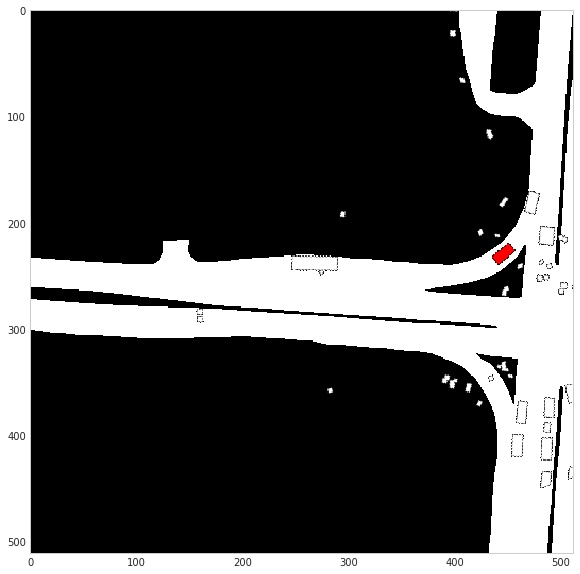

In [51]:
instance_token_img, sample_token_img = 'bc38961ca0ac4b14ab90e547ba79fbb6', 'e0845f5322254dafadbbed75aaa07969'
my_scene = nusc.scene[0]
my_scene_token = my_scene['token']
scene_rec = nusc.get('scene', my_scene_token)
first_sample_token = scene_rec['first_sample_token']
curr_sample_token = first_sample_token
sample_rec = nusc.get('sample', curr_sample_token)
first_ego_pose = get_ego_pose(sample_rec)
curr_frame = 20
for x in range(curr_frame-1):
    curr_sample_token = sample_rec['next']
    sample_rec = nusc.get('sample', curr_sample_token)
ego_pose = get_ego_pose(sample_rec)


img = mtp_input_representation.make_input_representation(ego_pose, ref_ego_pose, instance_token_img, curr_sample_token)

print('delx is {} meters, dely is {} meters'\
      .format(ego_pose['translation'][0]-first_ego_pose['translation'][0],\
              ego_pose['translation'][1]-first_ego_pose['translation'][1]))
plt.figure(figsize=(20,10))
plt.grid(False)
plt.imshow(img)

In [15]:
nusc.scene[0]

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

## Generate For All 85 scenes in part 1 of dataset

In [8]:
import colorsys
import os

import cv2
import numpy as np
from pyquaternion import Quaternion

from nuscenes.eval.common.utils import quaternion_yaw
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.prediction.helper import angle_of_rotation, angle_diff
from nuscenes.prediction.input_representation.combinators import Rasterizer
from nuscenes.prediction.input_representation.interface import \
    StaticLayerRepresentation, AgentRepresentation
from nuscenes.prediction.input_representation.utils import get_crops, get_rotation_matrix, convert_to_pixel_coords

import matplotlib.pyplot as plt
%matplotlib inline

from nuscenes.prediction.input_representation.combinators import Rasterizer
from nuscenes.prediction import PredictHelper

from typing import Any, Dict, List, Tuple, Callable

from nuscenes.prediction.helper import quaternion_yaw

%matplotlib inline
from nuscenes.nuscenes import NuScenes
import matplotlib.pyplot as plt
import numpy as np
import copy
import PIL
import os
from skimage import color
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from nuscenes.utils.data_classes import LidarPointCloud
from pyquaternion import Quaternion
nusc = NuScenes(version='v1.0-trainval', dataroot='/datasets/home/44/344/abkandoi/nuscenes-full-data', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 47.3 seconds.
Reverse indexing ...
Done reverse indexing in 14.5 seconds.


In [31]:
helper = PredictHelper(nusc)

static_layer_rasterizer = StaticLayerRasterizer2(helper, layer_names=['drivable_area'], resolution=0.5, meters_ahead = 64, meters_behind = 64,meters_left = 64, meters_right=64)
agent_rasterizer = OtherVehicleRepresentation(helper, resolution=0.5, meters_ahead = 64, meters_behind = 64,meters_left = 64, meters_right=64)
road_rep = InputRepresentationStaticOnly(static_layer_rasterizer, agent_rasterizer, Rasterizer())

static_layer_rasterizer2 = StaticLayerRasterizer2(helper, layer_names=['lane_divider'], resolution=0.5, meters_ahead = 64, meters_behind = 64,meters_left = 64, meters_right=64)
agent_rasterizer2 = OtherVehicleRepresentation(helper, resolution=0.5, meters_ahead = 64, meters_behind = 64,meters_left = 64, meters_right=64)
lane_rep = InputRepresentationStaticOnly(static_layer_rasterizer2, agent_rasterizer2, Rasterizer())

static_layer_rasterizer3 = StaticLayerRasterizer2(helper, layer_names=['walkway'], resolution=0.5, meters_ahead = 64, meters_behind = 64,meters_left = 64, meters_right=64)
agent_rasterizer3 = ObstacleAgentRepresentation(helper, resolution=0.5, meters_ahead = 64, meters_behind = 64,meters_left = 64, meters_right=64)
obstacle_rep = InputRepresentationBoth(static_layer_rasterizer3, agent_rasterizer3, Rasterizer())

static_layer_rasterizer4 = StaticLayerRasterizer2(helper, layer_names=['drivable_area'], resolution=0.5, meters_ahead = 64, meters_behind = 64,meters_left = 64, meters_right=64)
agent_rasterizer4 = OtherVehicleRepresentation(helper, resolution=0.5, meters_ahead = 64, meters_behind = 64,meters_left = 64, meters_right=64)
other_rep = InputRepresentationAgentOnly(static_layer_rasterizer4, agent_rasterizer4, Rasterizer())

static_layer_rasterizer5 = StaticLayerRasterizer2(helper, layer_names=['drivable_area'], resolution=0.5, meters_ahead = 64, meters_behind = 64,meters_left = 64, meters_right=64)
agent_rasterizer5 = TargetVehicleRepresentation(helper, resolution=0.5, meters_ahead = 64, meters_behind = 64,meters_left = 64, meters_right=64)
target_rep = InputRepresentationAgentOnly(static_layer_rasterizer5, agent_rasterizer5, Rasterizer())

static_layers.py - Loading Map: boston-seaport
static_layers.py - Loading Map: singapore-hollandvillage
static_layers.py - Loading Map: singapore-queenstown
static_layers.py - Loading Map: singapore-onenorth
static_layers.py - Loading Map: boston-seaport
static_layers.py - Loading Map: singapore-hollandvillage
static_layers.py - Loading Map: singapore-queenstown
static_layers.py - Loading Map: singapore-onenorth
static_layers.py - Loading Map: boston-seaport
static_layers.py - Loading Map: singapore-hollandvillage
static_layers.py - Loading Map: singapore-queenstown
static_layers.py - Loading Map: singapore-onenorth
static_layers.py - Loading Map: boston-seaport
static_layers.py - Loading Map: singapore-hollandvillage
static_layers.py - Loading Map: singapore-queenstown
static_layers.py - Loading Map: singapore-onenorth
static_layers.py - Loading Map: boston-seaport
static_layers.py - Loading Map: singapore-hollandvillage
static_layers.py - Loading Map: singapore-queenstown
static_laye

Generating for scene idx, 1, name:scene-0002
current_frame is  4
11


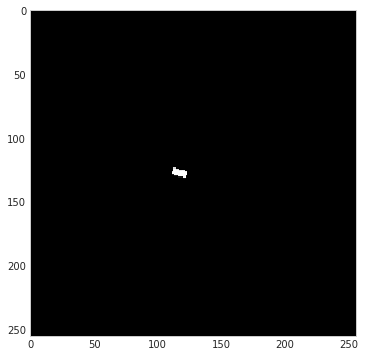

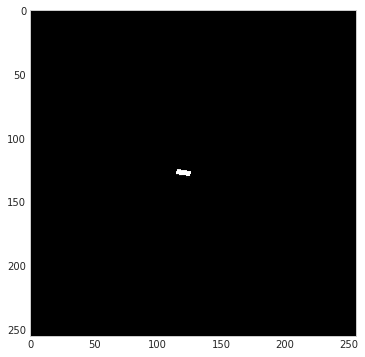

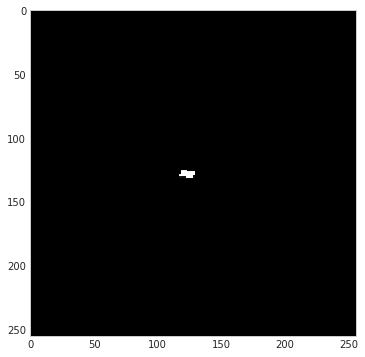

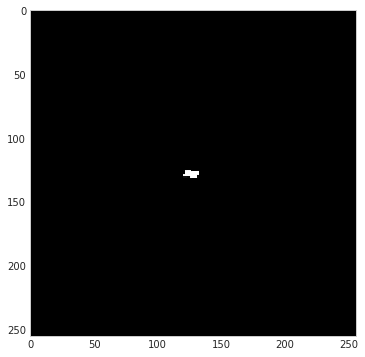

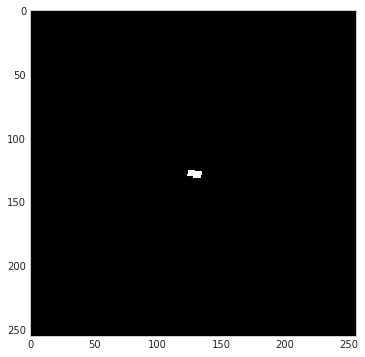

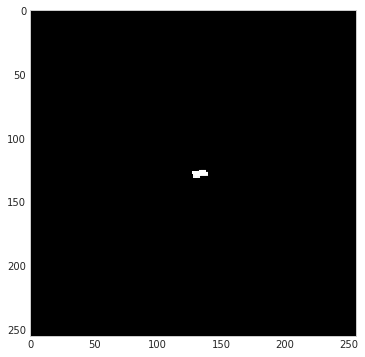

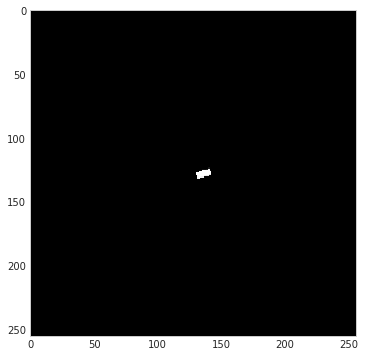

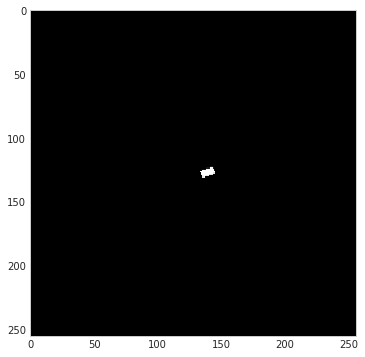

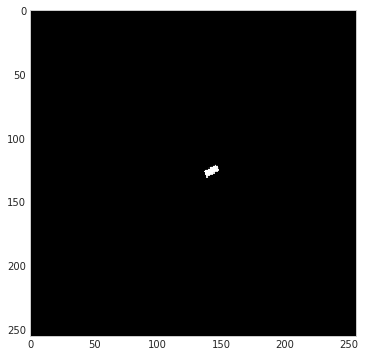

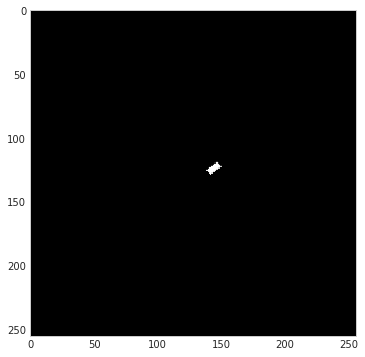

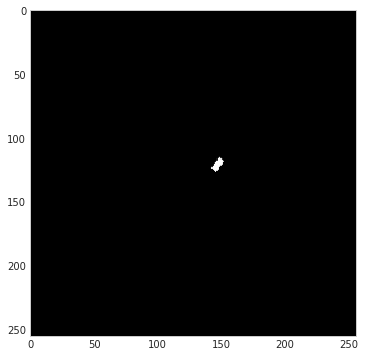

In [35]:
past_seconds = 2
future_seconds = 4

for j in range(1,len(nusc.scene)//10):
    print('Generating for scene idx, {}, name:{}'.format(j, nusc.scene[j]['name']))
    my_scene_token = nusc.scene[j]['token']
    scene_rec = nusc.get('scene', my_scene_token)

    current_token = scene_rec['first_sample_token']
    current_seq = []
    
    #for i in range(scene_rec['nbr_samples']):
    for i in range(12):
        #get current sample data
        sample_rec = nusc.get('sample', current_token)
        
        pointsensor_token = sample_rec['data']['LIDAR_TOP']
        pointsensor = nusc.get('sample_data', pointsensor_token)
        #get ego vehicle pose
        pose_record = nusc.get('ego_pose', pointsensor['ego_pose_token'])
        
        current_seq.append(pose_record)
        
        if len(current_seq) >= 12:
            current_frame = i - 2*future_seconds + 1
            print('current_frame is ', current_frame)
            
            time_frame = current_seq[current_frame-2*past_seconds:-1]
            print(len(time_frame))
            ref_ego_pose = current_seq[current_frame]
            
            count = 0
            for ego_pose in time_frame:
                target_chan = target_rep.make_input_representation(ego_pose, ref_ego_pose, '', current_token)
                other_chan = other_rep.make_input_representation(ego_pose, ref_ego_pose, '', current_token)
                obstacle_chan = obstacle_rep.make_input_representation(ego_pose, ref_ego_pose, '', current_token)
                road_chan = road_rep.make_input_representation(ego_pose, ref_ego_pose, '', current_token)
                lane_chan = lane_rep.make_input_representation(ego_pose, ref_ego_pose, '', current_token)
                plt.figure(figsize=(12,6))
                plt.grid(False)
                plt.imshow(target_chan)
                count+=1
        # next sample
        current_token = sample_rec['next']
    break